# Parcial: Construcción e implementación de , Random Forest 

En este parcial podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de  Random Forest. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este parcial se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [8]:
#librerias
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


In [3]:
# Importación de librerías
%matplotlib inline
import pandas as pd

# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data = data.drop(['Model'], axis=1)

# Visualización dataset
data.head()

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
7,21995,2014,6480,False,False,False,True,False,False,False
11,13995,2014,39972,False,False,False,False,True,False,False
167,17941,2016,18989,False,False,False,False,False,True,False
225,12493,2014,51330,False,False,False,True,False,False,False
270,7994,2007,116065,False,True,False,False,False,False,False


In [4]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['Price']
X = data.drop(['Price'], axis=1)

In [5]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Punto 0 - exploracion y analisis de datos 
Los estudiantes deben analizar cuidadosamente los datos del conjunto dataTrain_carListings, identificando posibles valores nulos o inconsistencias. En caso de encontrar datos faltantes, deberán aplicar técnicas de imputación adecuadas para completar la información de manera coherente. Posteriormente, se espera que realicen una exploración visual mediante gráficos que permitan comprender la distribución y las relaciones entre las variables principales.

Valores nulos:
Price          0
Year           0
Mileage        0
M_Camry        0
M_Camry4dr     0
M_CamryBase    0
M_CamryL       0
M_CamryLE      0
M_CamrySE      0
M_CamryXLE     0
dtype: int64

Estadísticas descriptivas:
              Price          Year        Mileage
count  10495.000000  10495.000000   10495.000000
mean   14538.403716   2013.553883   52509.430395
std     3922.420961      3.116585   36791.736601
min     5002.000000   1998.000000       5.000000
25%    11999.000000   2012.000000   26461.000000
50%    15000.000000   2014.000000   41680.000000
75%    16999.000000   2016.000000   71355.500000
max    32444.000000   2018.000000  232658.000000


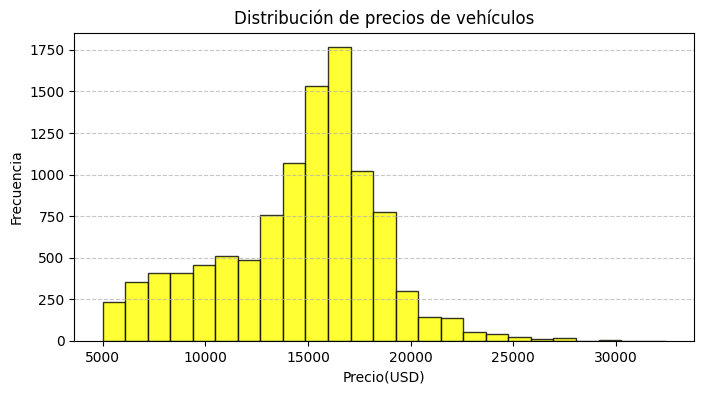

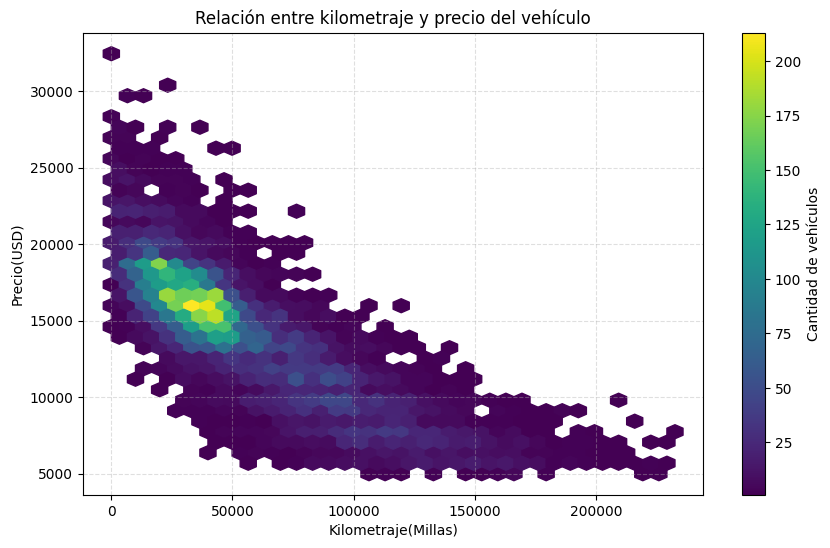

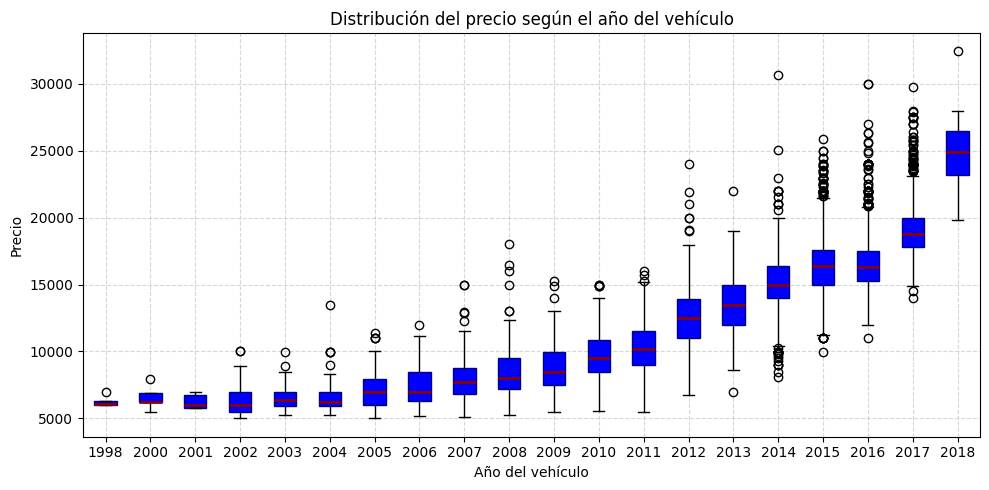

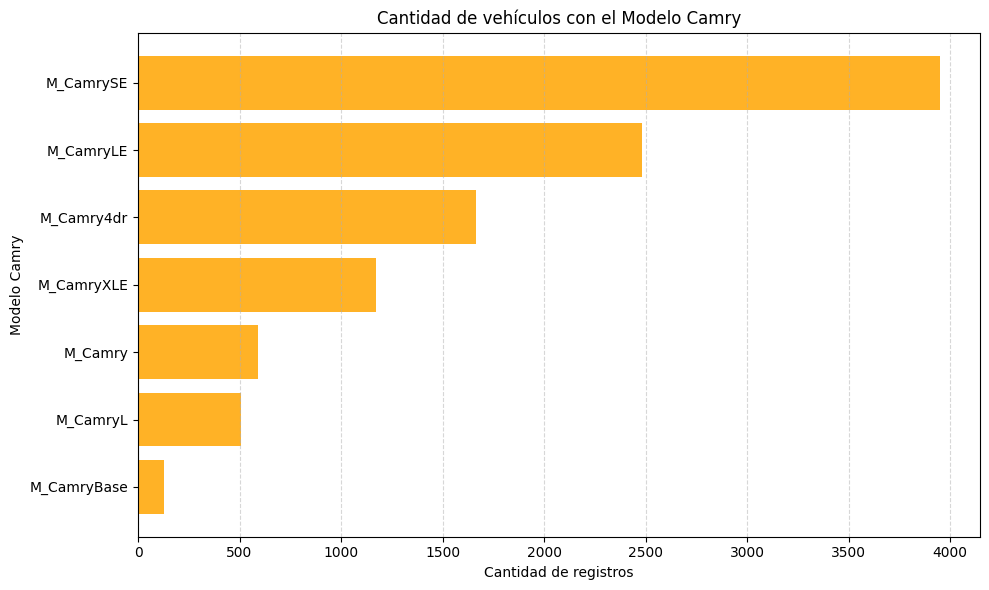

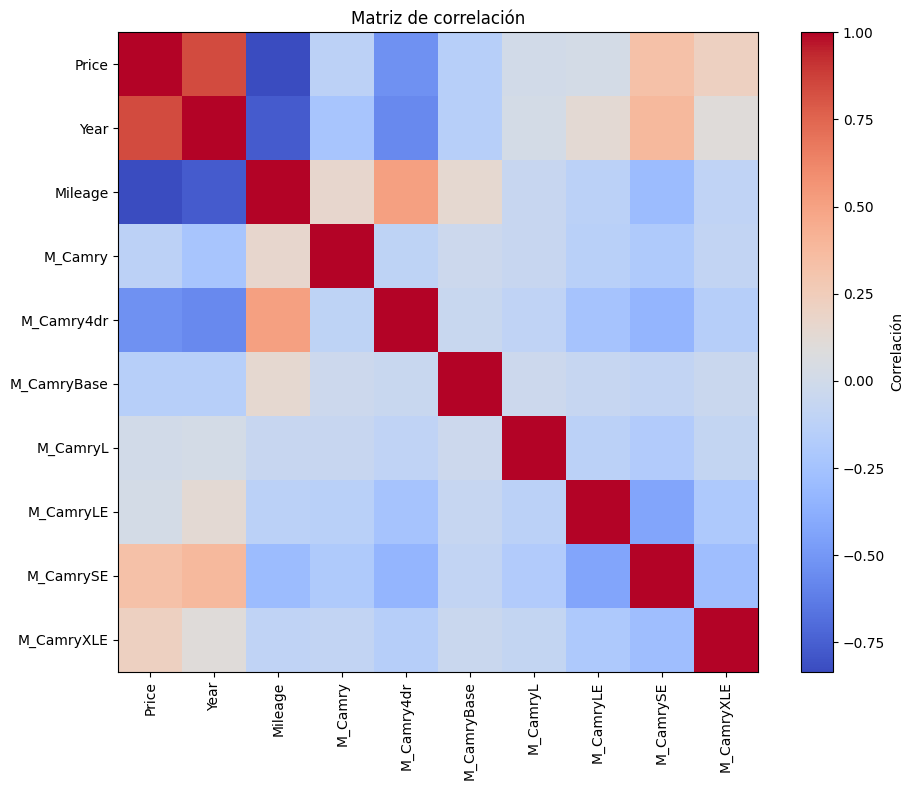

In [53]:
# celda 0 - exploracion y analisis de datos
print("Valores nulos:")
print(data.isnull().sum())

print("\nEstadísticas descriptivas:")
print(data.describe())

#Gráfica de Distribución del precio
plt.figure(figsize=(8, 4))
plt.hist(data['Price'], bins=25, color='yellow', edgecolor='black', alpha=0.8)
plt.title('Distribución de precios de vehículos')
plt.xlabel('Precio(USD)')
plt.ylabel('Frecuencia')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#Gráfica de Precio vs Kilometraje
plt.figure(figsize=(10, 6))
plt.hexbin(data['Mileage'], data['Price'], gridsize=35, cmap='viridis', mincnt=1)
plt.colorbar(label='Cantidad de vehículos')
plt.title('Relación entre kilometraje y precio del vehículo')
plt.xlabel('Kilometraje(Millas)')
plt.ylabel('Precio(USD)')
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()

#Gráfica de Precios por año
plt.figure(figsize=(10, 5))
years_sorted = sorted(data['Year'].unique())
plt.boxplot(
    [data[data['Year'] == y]['Price'] for y in years_sorted],
    labels=years_sorted,
    patch_artist=True,
    boxprops=dict(facecolor='blue', color='navy'),
    medianprops=dict(color='darkred', linewidth=2)
)
plt.title('Distribución del precio según el año del vehículo')
plt.xlabel('Año del vehículo')
plt.ylabel('Precio')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

#Gráfica de Cantidad de vehículos por Modelo Camry
plt.figure(figsize=(10, 6))
model_cols = [col for col in data.columns if col.startswith('M_')]
model_counts = data[model_cols].sum().sort_values(ascending=True)
plt.barh(model_counts.index, model_counts.values, color='orange', alpha=0.85)
plt.title('Cantidad de vehículos con el Modelo Camry')
plt.xlabel('Cantidad de registros')
plt.ylabel('Modelo Camry')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

#Gráfica de Matriz de correlación
plt.figure(figsize=(10, 8))
corr_matrix = data.corr()
plt.imshow(corr_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar(label='Correlación')
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
plt.title('Matriz de correlación')
plt.tight_layout()
plt.show()

### Punto 1 - Random forest con librería

En la celda 1, usando la librería sklearn entrenen un modelo de Randon Forest para regresion  y comenten sobre el desempeño del modelo.

In [29]:
# Celda 1
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Desempeño del modelo:")
print(f"R²: {r2}")
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

Desempeño del modelo:
R²: 0.7827584908775596
MAE: 1341.5903648004503
RMSE: 1814.658321308918


### Punto 2 - Calibración de parámetros Random forest

En la celda 2, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para regresion, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

In [72]:
# Celda 2
#Encontrar los mejores hiperparametros: 
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20], 
    'max_features': ['auto', 'sqrt', 'log2'] 
}

grid_search = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid,
    cv=5,
    n_jobs=-1,
    scoring='r2'
)
grid_search.fit(X_train, y_train)
print("Mejores Hiperparámetros:")
print(grid_search.best_params_)

Mejores Hiperparámetros:
{'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 300}


In [65]:
#Entrenar el modelo con los mejores hiperparámetros encontrados:
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

y_pred_best = best_model.predict(X_test)

mae_best = mean_absolute_error(y_test, y_pred_best)
rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))
r2_best = r2_score(y_test, y_pred_best)

print("Desempeño del modelo optimizado:")
print(f"R²: {r2_best}")
print(f"MAE: {mae_best}")
print(f"RMSE: {rmse_best}")

Desempeño del modelo optimizado:
R²: 0.8313525258975243
MAE: 1160.2373818392957
RMSE: 1598.8708309135652


In [45]:
#Importancia de los predictores
importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Importancia de las variables:")
print(importances)

Importancia de las variables:
       Feature  Importance
0         Year    0.445329
1      Mileage    0.428310
3   M_Camry4dr    0.065917
7    M_CamrySE    0.021910
8   M_CamryXLE    0.019081
6    M_CamryLE    0.007238
2      M_Camry    0.006259
5     M_CamryL    0.003097
4  M_CamryBase    0.002859


### Punto 3 - análisis de resultados, gracias y conclusiones
En la celda 3

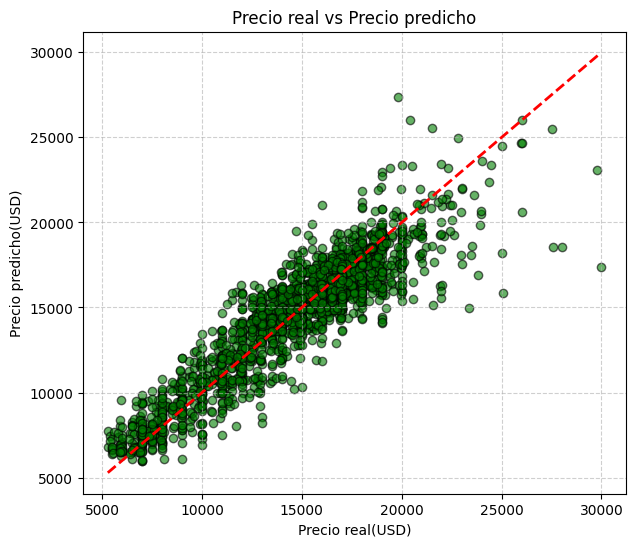

Conclusiones: 
El modelo de Random Forest mostró un desempeño sólido en la predicción de precios de vehículos con un R² de 0.83,
lo que demuestra una alta capacidad para capturar las relaciones entre las variables.
El MAE significa que en promedio el modelo se desvía del precio real en aproximadamente 1,160 dolares.
El RMSE de 1,598 significa que los errores más grandes están bien controlados y no existen desviaciones extremas.
Con el diagrama de correlación las variables (Año, Kilometraje, Modelo) influyen en su precio del mercado.
El modelo presenta una buena presición y estabilidad capaz de estimar correctamente el precio de los vehículos.


In [71]:
#celda 3
plt.figure(figsize=(7, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='green', edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title('Precio real vs Precio predicho')
plt.xlabel('Precio real(USD)')
plt.ylabel('Precio predicho(USD)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

print("Conclusiones: ")
print("El modelo de Random Forest mostró un desempeño sólido en la predicción de precios de vehículos con un R² de 0.83,"
"\nlo que demuestra una alta capacidad para capturar las relaciones entre las variables.")
print("El MAE significa que en promedio el modelo se desvía del precio real en aproximadamente 1,160 dolares.")
print("El RMSE de 1,598 significa que los errores más grandes están bien controlados y no existen desviaciones extremas.")
print("Con el diagrama de correlación las variables (Año, Kilometraje, Modelo) influyen en su precio del mercado.")
print("El modelo presenta una buena presición y estabilidad capaz de estimar correctamente el precio de los vehículos.")



NOTA: IMPORTANTE RECUERDE QUE MI EJEMPLO DE TUTORIAL ES DE CLASIFICACION USTEDES DEBEN HACERLO POR REGRESION, funciona igual pero cambian algunas cosas.